# Supporting code and data for "Impact of switching bug trackers: a case study"

## Data collection

Given that creation dates of migrated bugs and comments were preserved during the GitHub import, we can extract and analyze data from before / after the switch by querying the GitHub API only. We will specifically use the GitHub GraphQL API because it allows fetching only the information we need, and at a much faster rate (we can get up to 100 nodes in a single request). Getting all the objects of a certain type requires then to repeat the request to go through all the pages of results.

Set `update_data_from_GitHub` to `True` and provide a personal `api_token` if you want to get fresh data from GitHub. Otherwise, this notebook will skip the data collection step and load the provided CSV files that were produced with this code on September 14th, 2018.

In [0]:
#@title GitHub API settings { run: "auto", display-mode: "form" }
update_data_from_GitHub = False #@param {type:"boolean"}
api_token = "" #@param {type:"string"}

In [0]:
import csv
import requests

def requestAllPages(query,rows_and_next_variables,filename,columns):
  if not update_data_from_GitHub:
    return
  headers = {'Authorization': f'token {api_token}'}
  url = 'https://api.github.com/graphql'
  rows, variables = rows_and_next_variables(None)
  while len(variables)>0:
    json = {'query':query,'variables':variables.pop()}
    r = requests.post(url=url, json=json, headers=headers)
    r.raise_for_status() # Abort if unsuccessful request
    new_rows, next_variables = rows_and_next_variables(r.json()['data'])
    rows += new_rows
    variables += next_variables
  if len(rows) > 0:
    with open(filename, 'w') as f:
      writer = csv.writer(f)
      writer.writerow(columns)
      writer.writerows(rows)

We identify migrated issues because their creation date is before October 18th, 2017. For all the migrated issues, we need to request the body of the issue to be able to extract information on the reporter. As soon as we are requesting only issues beyond the migration date, we stop requesting the body.

We keep information on the number of the issue (or the pull request) to be able to match comments and issues (or comments and pull request).

In [0]:
import re
import pandas as pd

migration_date = pd.datetime(2017,10,18)

def local():

  query = """
    query issueQuery($owner: String!, $repo: String!, $bodyText: Boolean!, $cursor: String) {
      repository(owner: $owner, name: $repo) {
        issues(first: 100, after: $cursor, orderBy:{field: CREATED_AT, direction:ASC}) {
          pageInfo {
            endCursor
            hasNextPage
          }
          nodes {
            createdAt
            author { login }
            bodyText @include (if: $bodyText)
            number
          }
        }
      }
    }
  """

  def rows_and_next_variables(data):
    if data is None:
      return [], [{'owner':'coq','repo':'coq','bodyText':True}]
    else:
      rows = []
      issues = data['repository']['issues']
      for node in issues['nodes']:
        date = pd.to_datetime(node['createdAt'])
        post_migration = date >= migration_date
        if post_migration:
          author = node['author']['login']
        else:
          m = re.search('From: @?(.*)', node['bodyText'])
          author = m.group(1)        
        rows.append([date,author,post_migration,node['number']])
      if issues['pageInfo']['hasNextPage']:
        return rows, [{'owner':'coq',
                       'repo':'coq',
                       'bodyText':not rows[-1][2],
                       'cursor':issues['pageInfo']['endCursor']
                      }]
      else:
        return rows, []

  requestAllPages(
      query,
      rows_and_next_variables,
      'issues.csv',
      ['date','author','post_migration','number']
  )

local()

In [0]:
def local():

  query = """
    query pullRequestQuery($owner: String!, $repo: String!, $cursor: String) {
      repository(owner: $owner, name: $repo) {
        pullRequests(first: 100, after: $cursor) {
          pageInfo {
            endCursor
            hasNextPage
          }
          nodes {
            createdAt
            author { login }
            number
          }
        }
      }
    }
  """

  def rows_and_next_variables(data):
    if data is None:
      return [], [{'owner':'coq','repo':'coq'}]
    else:
      rows = []
      pullRequests = data['repository']['pullRequests']
      for node in pullRequests['nodes']:
        rows.append([node['createdAt'],node['author']['login'],node['number']])
      if pullRequests['pageInfo']['hasNextPage']:
        return rows, [{'owner':'coq',
                       'repo':'coq',
                       'cursor':pullRequests['pageInfo']['endCursor']
                      }]
      else:
        return rows, []

  requestAllPages(
      query,
      rows_and_next_variables,
      'pullrequests.csv',
      ['createdAt','author','number']
  )

local()

In [0]:
def local():

  query = """
    query commentQuery($owner: String!, $repo: String!, $number: Int!, $single: Boolean!, $issueCursor: String, $commentCursor: String) {
      repository(owner: $owner, name: $repo) {
        issues(first: 100, after: $issueCursor, orderBy:{field: CREATED_AT, direction:ASC}) @skip (if: $single) {
          pageInfo {
            endCursor
            hasNextPage
          }
          nodes {
            ... issue
          }
        }
        issue(number: $number) @include (if: $single) {
          ... issue
        }
      }
    }

    fragment issue on Issue {
      number
      comments(first: 100, after: $commentCursor) {
        pageInfo {
          endCursor
          hasNextPage
        }
        nodes {
          createdAt
          author { login }
          bodyText
        }
      }
    }
  """

  def treat_issue(issue):
    number = issue['number']
    rows, variables = [], []
    for comment in issue['comments']['nodes']:
      date = pd.to_datetime(comment['createdAt'])
      post_migration = date >= migration_date
      if post_migration:
        author = comment['author']['login']
      else:
        m = re.search('Comment author: @?(.*)', comment['bodyText'])
        if m is None:
          author = None
        else:
          author = m.group(1)      
      rows.append([date,author,post_migration,number])
    if issue['comments']['pageInfo']['hasNextPage']:
      variables += [{
          'owner':'coq',
          'repo':'coq',
          'single':True,
          'number':number,
          'commentCursor':issue['comments']['pageInfo']['endCursor']
      }]
    return rows, variables

  def rows_and_next_variables(data):
    if data is None:
      return [], [{'owner':'coq','repo':'coq','single':False,'number':0}]
    else:
      if 'issues' in data['repository']:
        issues = data['repository']['issues']
        rows, variables = [], []
        for issue in issues['nodes']:
          new_rows, new_variables = treat_issue(issue)
          rows += new_rows
          variables += new_variables
        if issues['pageInfo']['hasNextPage']:
          variables += [{
              'owner':'coq',
              'repo':'coq',
              'single':False,
              'number':0,
              'issueCursor':issues['pageInfo']['endCursor']
          }]
        return rows, variables
      else:
        return treat_issue(data['repository']['issue'])

  requestAllPages(
      query,
      rows_and_next_variables,
      'comments.csv',
      ['date','author','post_migration','number']
  )

local()

In [0]:
def local():

  query = """
    query commentQuery($owner: String!, $repo: String!, $number: Int!, $single: Boolean!, $prCursor: String, $commentCursor: String) {
      repository(owner: $owner, name: $repo) {
        pullRequests(first: 100, after: $prCursor, orderBy:{field: CREATED_AT, direction:ASC}) @skip (if: $single) {
          pageInfo {
            endCursor
            hasNextPage
          }
          nodes {
            ... pullRequest
          }
        }
        pullRequest(number: $number) @include (if: $single) {
          ... pullRequest
        }
      }
    }

    fragment pullRequest on PullRequest {
      number
      comments(first: 100, after: $commentCursor) {
        pageInfo {
          endCursor
          hasNextPage
        }
        nodes {
          createdAt
          author { login }
        }
      }
    }
  """

  def treat_pr(pr):
    rows, variables = [], []
    number = pr['number']
    for comment in pr['comments']['nodes']:
      date = pd.to_datetime(comment['createdAt'])
      post_migration = date >= migration_date
      rows.append([date,comment['author']['login'],post_migration,number])
    if pr['comments']['pageInfo']['hasNextPage']:
      variables += [{
          'owner':'coq',
          'repo':'coq',
          'single':True,
          'number':number,
          'commentCursor':pr['comments']['pageInfo']['endCursor']
      }]
    return rows, variables

  def rows_and_next_variables(data):
    if data is None:
      return [], [{'owner':'coq','repo':'coq','single':False,'number':0}]
    else:
      if 'pullRequests' in data['repository']:
        prs = data['repository']['pullRequests']
        rows, variables = [], []
        for pr in prs['nodes']:
          new_rows, new_variables = treat_pr(pr)
          rows += new_rows
          variables += new_variables
        if prs['pageInfo']['hasNextPage']:
          variables += [{
              'owner':'coq',
              'repo':'coq',
              'single':False,
              'number':0,
              'prCursor':prs['pageInfo']['endCursor']
          }]
        return rows, variables
      else:
        return treat_pr(data['repository']['pullRequest'])

  requestAllPages(
      query,
      rows_and_next_variables,
      'pr_comments.csv',
      ['date','author','post_migration','number']
  )

local()

## Data pre-processing

In [7]:
import os

def load_csv(filename):
  
  def aux(filename):
    return pd.read_csv(filename,parse_dates=True,index_col=0)
  
  try:
    df = aux(filename)
    print(f'File retrieved from local file system: {filename}')
    return df
  except:
    url = f'https://raw.githubusercontent.com/Zimmi48/github-migration-analysis/commit-analysis/analysis/{filename}'
    df = aux(url)
    print(f'File retrieved from distant URL: {url}')
    return df

issues = load_csv('issues.csv')
prs = load_csv('pullrequests.csv')
comments = load_csv('comments.csv')
pr_comments = load_csv('pr_comments.csv')
commits = load_csv('commits.csv')

File retrieved from distant URL: https://raw.githubusercontent.com/Zimmi48/github-migration-analysis/commit-analysis/analysis/issues.csv
File retrieved from distant URL: https://raw.githubusercontent.com/Zimmi48/github-migration-analysis/commit-analysis/analysis/pullrequests.csv
File retrieved from distant URL: https://raw.githubusercontent.com/Zimmi48/github-migration-analysis/commit-analysis/analysis/comments.csv
File retrieved from distant URL: https://raw.githubusercontent.com/Zimmi48/github-migration-analysis/commit-analysis/analysis/pr_comments.csv
File retrieved from distant URL: https://raw.githubusercontent.com/Zimmi48/github-migration-analysis/commit-analysis/analysis/commits.csv


### Merging of duplicate Bugzilla accounts

The correspondence table between accounts used by the migration tool already allowed to merge several accounts together and  identify  individual  reporters.  When  we  discovered  later  on  that  some  reporter whose account had been not matched had created a GitHub account, we edited the imported bug reports and comments to use their GitHub nickname instead of their name and e-mail address as for unmatched Bugzilla reporters. There  are  also  some  duplicate  Bugzilla  accounts  that  have  no  corresponding GitHub  account.  For  our  (new) reporter  analysis,  we  still  need  to  merge  these.  We have identified such duplicate accounts visually so it is very likely that we have missed some but probably very few. Indeed, duplicates are usually very obvious because people have their name as part of their e-mail address (especially when they are using academic e-mail addresses).

In [8]:
to_merge = {
    'Alexandre.Miquel@pps.jussieu.fr':'Alexandre Miquel <miquel@ausone.inria.fr>',
    'Andreas Abel <andreas.abel@ifi.lmu.de>':'Andreas Abel <abela@chalmers.se>',
    'Benoit Montagu <benoit.montagu@m4x.org>':'Benoit Montagu <benoit.montagu@inria.fr>',
    'carlos@math1.unice.fr':'carlos@math.unice.fr',
    'Claude.Marche@inria.fr':'Claude.Marche@lri.fr',
    'marche@lri.fr':'Claude.Marche@lri.fr',
    'Clement.Renard@inria.fr':'Clement Renard <clrenard@pauillac.inria.fr>',
    'Damien.Pous@ens-lyon.fr':'Damien Pous <Damien.Pous@inria.fr>',
    'delahaye@cs.chalmers.se':'David.Delahaye@inria.fr',
    'Ed Morehouse <edmo@cs.cmu.edu>':'Ed Morehouse <emorehouse@wesleyan.edu>',
    'ethan.aubin@pobox.com':'ethan.aubin@gmail.com',
    'Francois Bobot <francois.bobot@cea.fr>':'François Bobot <bobot@lri.fr>',
    'François Pessaux <francois.pessaux@ensta-paristech.fr>':'François PESSAUX <francois_pessaux@yahoo.fr>',
    'hendriks@cs.kun.nl':'hendriks@cs.ru.nl',
    'mhendrik@cs.ru.nl':'hendriks@cs.ru.nl',
    'Jacek Chrząszcz <chrzaszcz@mimuw.edu.pl>':'Jacek Chrzaszcz <Jacek.Chrzaszcz@lri.fr>',
    'Jacek Chrząszcz <jacek.chrz@mailinator.com>':'Jacek Chrzaszcz <Jacek.Chrzaszcz@lri.fr>',
    'Jean-Marie Madiot <jm.madiot+lix+coq+bugs@gmail.com>':'Jean-Marie Madiot <madiot@gmail.com>',
    'Jonas B. Jensen <jbj@knef.dk>':'Jonas B. Jensen <jobr@itu.dk>',
    '=?ISO-8859-1?Q?Judica=EBl_Courant?= <Judicael.Courant@free.fr>':'Judicael.Courant@lri.fr',
    'Judicaël Courant <judicael.courant@imag.fr>':'Judicael.Courant@lri.fr',
    'loeb@cs.kun.nl':'loeb@cs.ru.nl',
    'Peter LeFanu Lumsdaine <p.l.lumsdaine@gmail.com>':'Peter LeFanu Lumsdaine <plumsdaine@ias.edu>',
    'Philippe Audebaud <Philippe.Audebaud@ens-lyon.fr>':'Philippe.Audebaud@sophia.inria.fr',
    'samuel.mimram@ens-lyon.org':'Samuel Mimram <samuel.mimram@ens-lyon.fr>',
    'Solange Coupet_Grimal <Solange.Coupet_Grimal@sophia.inria.fr>':'Solange Coupet-Grimal <Solange.Coupet@cmi.univ-mrs.fr>',
    'Steven Tschantz <stt314@comcast.net':'Steven Tschantz <steven.tschantz@vanderbilt.edu>',
    'virgile.prevosto@m4x.org':'virgile.prevosto@lip6.fr'
}

issues = issues.assign(
    author = [to_merge[author] if author in to_merge else author for author in issues['author']]
)

print('After merging duplicates account, we have %d distinct bug reporters.' % issues.nunique()['author'])

nb_of_reporters_before_the_switch = issues[issues.index < migration_date].nunique()['author']
print('%d of them were active before the switch' % nb_of_reporters_before_the_switch)

After merging duplicates account, we have 710 distinct bug reporters.
607 of them were active before the switch


We also computed the number of Bugzilla accounts before the migration by running `grep "<reporter[> ]" bugzilla.xml | cut -d'>' -f 2 | cut -d'<' -f 1 | sort | uniq | wc -l` (`bugzilla.xml` being the XML dump of the Bugzilla reports at the time of the migration). The result is 686. Thus, all in all:

In [9]:
bugzilla_account_duplicate_nb = 686 - nb_of_reporters_before_the_switch
print(f'We have identified {bugzilla_account_duplicate_nb} duplicate Bugzilla accounts.')
print('This represents %d%% of all Bugzilla accounts.' % (round(bugzilla_account_duplicate_nb / nb_of_reporters_before_the_switch * 100)))

We have identified 79 duplicate Bugzilla accounts.
This represents 13% of all Bugzilla accounts.


### Removal of migration artifact comments

If a comment was posted exactly at the same date and time as the corresponding issue, then it means that it is an artifact of the bug migration.

In [0]:
issues_by_number = issues.assign(date=issues.index).set_index('number')
comments = comments[
    [date != issues_by_number.loc[row['number']]['date']
     for date, row in comments.iterrows()]
]

### Only consider post-2008 data

Bugs and comments from July, 2007 and before were migrated a first time from a previous bug tracker (JitterBug). Comments do not have valid author information and closed bugs have not been migrated.

In [0]:
comments = comments[comments.index >= pd.datetime(2008,1,1)]
issues = issues[issues.index >= pd.datetime(2008,1,1)]

### Excluding specific reporters

- We have one particular reporter / contributor, Jason Gross, who is alone responsible for creating almost a quarter (24%) of all bug reports (and an even greater proportion when we only consider post-2008 bug reports). To avoid having the behavior of a single individual strongly impact the overall statistics, we exclude his comments, bug reports and pull requests and all the comments they received from our analysis.
- We also exclude from this analysis the developer who was the initiator and conductor of the bug tracker switch and migration and who is an author of this analysis.

In [12]:
def local():

  nb_of_reports_by_Jason_Gross = len(issues[issues['author'] == 'JasonGross'])
  total_nb_of_reports = len(issues)

  print(f'Number of post-2008 bug reports: {total_nb_of_reports}')
  print(f'Reports by Jason Gross: {nb_of_reports_by_Jason_Gross}')
  print('Overall proportion: %d%%' % (nb_of_reports_by_Jason_Gross / total_nb_of_reports * 100))

local()

Number of post-2008 bug reports: 5167
Reports by Jason Gross: 1449
Overall proportion: 28%


In [0]:
excluded_reporters = ['JasonGross','Zimmi48']

excluded_issues = issues[issues['author'].isin(excluded_reporters)]['number'].values

comments = comments[~comments['number'].isin(excluded_issues) & ~comments['author'].isin(excluded_reporters)]
issues = issues[~issues['author'].isin(excluded_reporters)]

excluded_prs = prs[prs['author'].isin(excluded_reporters)]['number'].values

pr_comments = pr_comments[~pr_comments['number'].isin(excluded_prs) & ~pr_comments['author'].isin(excluded_reporters)]
prs = prs[~prs['author'].isin(excluded_reporters)]

This should not be forgotten when interpreting *absolute* values of results.

### Exclude anonymous commits

In [14]:
def local():
  
  all_commits = len(commits)
  anonymous_commits = len(commits[commits['author']=='anonymous'])
  
  print(f'Total number of commits (excluding merge commits): {all_commits}')
  print(f'Number of anonymous commits: {anonymous_commits}')
  
local()

Total number of commits (excluding merge commits): 24467
Number of anonymous commits: 636


Even if there are very few anonymous commits compared to the total number of commits, these are not evenly spread out. The following analysis shows the months which contain more than 10% anonymous commits. These are one month of 2000 with one anonymous commit out of 6 commits, the months of September and October 2002 and all the year of 2005 + the first three months of 2006, with ratio going as high as 88% of all commits. While each of these cases is likely to be due to a single committer having incorrectly configured their machine, it makes any kind of analysis impossible for these periods (for instance because the anonymous committer could also have non-anonymous commits coming from another machine).

In [15]:
def local():
  
  commits_by_month = commits.assign(count=1,anonymous=commits['author']=='anonymous').resample('1M').agg({'count':'sum','anonymous':'sum'})
  commits_by_month = commits_by_month.assign(ratio=commits_by_month['anonymous']/commits_by_month['count'])
  return commits_by_month[commits_by_month['ratio'] > 0.1]
  
local()

,count,anonymous,ratio
date,,,
2000-08-31,6,1.0,0.166667
2002-08-31,21,10.0,0.476190
2002-09-30,46,5.0,0.108696
2004-12-31,109,31.0,0.284404
2005-01-31,69,37.0,0.536232
2005-02-28,97,36.0,0.371134
2005-03-31,80,46.0,0.575000
2005-04-30,41,36.0,0.878049
2005-05-31,86,43.0,0.500000


There are no more anonymous commits after 2006-03-05. So we restrict the analysis from there.

In [0]:
commits = commits[commits.index > pd.datetime(2006,3,6)]

### Sort commits by date

In [0]:
commits = commits.sort_index()

## Variables

### Developers


The following list was obtained by running `git shortlog -ns --after=2008-01-01 | awk '$1 > 100'` on 2018-09-14, which is the day we gathered the rest of the data. It corresponds to the people who have authored more than 100 commits since 2008.

```
  2824  Hugo Herbelin
  2559  Pierre-Marie Pédrot
  2006  Maxime Dénès
  1624  Matthieu Sozeau
  1480  Pierre Letouzey
   950  Enrico Tassi
   599  Emilio Jesus Gallego Arias
   540  Arnaud Spiwack
   508  Théo Zimmermann
   489  Gaëtan Gilbert
   438  Pierre Boutillier
   418  Guillaume Melquiond
   299  Jason Gross
   287  Matej Košík
   238  Stéphane Glondu
   151  Jean-Marc Notin
   128  Bruno Barras
```

We will call "developers" the members of this list and "others" the rest of the bug reporters / pull request authors.

We also define a sub-list of these "developers" that were active during the two months preceding the migration by running `comm -12 <(git shortlog -s --after=2008-01-01 | awk '$1 > 100' | cut -f2) <(git shortlog -s --after=2017-08-18 --before=2017-10-17 | cut -f2 | sort)`, the result being:

```
Emilio Jesus Gallego Arias
Enrico Tassi
Gaëtan Gilbert
Guillaume Melquiond
Hugo Herbelin
Jason Gross
Matthieu Sozeau
Maxime Dénès
Pierre Letouzey
Pierre-Marie Pédrot
Théo Zimmermann
```

The other part of the list (`comm -23 <(git shortlog -s --after=2008-01-01 | awk '$1 > 100' | cut -f2) <(git shortlog -s --after=2017-08-18 --before=2017-10-17 | cut -f2 | sort)`) is thus:

```
Arnaud Spiwack
Bruno Barras
Jean-Marc Notin
Matej Košík
Pierre Boutillier
Stéphane Glondu
```

In [0]:
active_devs = [
    'ejgallego', # Emilio Jesus Gallego Arias
    'gares', # Enrico Tassi
    'SkySkimmer', # Gaëtan Gilbert
    'silene', # Guillaume Melquiond
    'herbelin', # Hugo Herbelin
    'JasonGross', # Jason Gross
    'mattam82', # Matthieu Sozeau
    'maximedenes', # Maxime Dénès
    'letouzey', # Pierre Letouzey
    'ppedrot', # Pierre-Marie Pédrot
    'Zimmi48' # Théo Zimmermann
]

devs = active_devs + [
    'aspiwack', # Arnaud Spiwack
    'barras', # Bruno Barras
    'Jean-Marc Notin <notin@lix.polytechnique.fr>', # Jean-Marc Notin
    'matejkosik', # Matej Košík
    'pirbo', # Pierre Boutillier
    'glondu' # Stéphane Glondu
]

### Time periods

We will usually work with 15-day periods to have enough bug reports but we will rather use 30-day periods when analysing new reporter / commentator information because we would get values that are too low otherwise. Our time periods are "centered" around the bug tracker switch date (they have a "reldate" field which is zero for the first period after the switch, postive for subsequent periods and negative for periods before the switch). We also define a number of outcome variables.

In [0]:
import numpy as np

def df_15D_30D(df):
  dev = df['author'].isin(devs)
  reldays = (df.index-migration_date).days
  
  df = df.assign(
      count=1,
      dev_count=dev,
      other_count=~dev,
      dev_author=[author if author in devs else np.NaN for author in df['author']],
      other_author=[author if not author in devs else np.NaN for author in df['author']],
      new=~df.duplicated(subset=['author']),
      reldate_15D=np.round(reldays/15),
      reldate_30D=np.round(reldays/30),
      date=df.index
  )
  
  def group_by_reldate(key_suffix):
    agg = {
        'count':'sum',
        'dev_count':'sum',
        'other_count':'sum',
        'author':'nunique',
        'dev_author':'nunique',
        'other_author':'nunique',
        'new':'sum',
        'date':'max'
    }

    grouped = df.groupby(f'reldate{key_suffix}').agg(agg).iloc[1:-1]
    return grouped.assign(
        reldate=grouped.index,
        after_switch=(grouped.index>=0)
    ).set_index('date')
  
  return df,group_by_reldate('_15D'),group_by_reldate('_30D')

In [20]:
issues,issues_15D,issues_30D = df_15D_30D(issues)

print(
    f'Average number of bug reports by 15-day period (since 2008): %d' %
    issues_15D.mean()['count']
)

print('Quantiles of bug reports by 15-day period (since 2008):')
print(issues_15D.quantile([.1, .25, .5, .75, .9])['count'])

print(
    f'\n\nAverage number of new reporters by 30-day period (since 2008): %d' %
    issues_30D.mean()['new']
)

print('Quantiles of new reporters by 30-day period (since 2008):')
print(issues_30D.quantile([.1, .25, .5, .75, .9])['new'])

Average number of bug reports by 15-day period (since 2008): 13
Quantiles of bug reports by 15-day period (since 2008):
0.10     4.0
0.25     7.0
0.50    11.0
0.75    18.0
0.90    28.0
Name: count, dtype: float64


Average number of new reporters by 30-day period (since 2008): 4
Quantiles of new reporters by 30-day period (since 2008):
0.10    1.0
0.25    2.0
0.50    4.0
0.75    6.0
0.90    8.0
Name: new, dtype: float64


In [21]:
comments,comments_15D,comments_30D = df_15D_30D(comments)

print(
    f'Average number of bug comments by 15-day period (since 2008): %d' %
    comments_15D.mean()['count']
)

print('Quantiles of bug comments by 15-day period (since 2008):')
print(comments_15D.quantile([.1, .25, .5, .75, .9])['count'])

print(
    f'\n\nAverage number of new commentators by 30-day period (since 2008): %d' %
    comments_30D.mean()['new']
)

print('Quantiles of new commentators by 30-day period (since 2008):')
print(comments_30D.quantile([.1, .25, .5, .75, .9])['new'])

Average number of bug comments by 15-day period (since 2008): 43
Quantiles of bug comments by 15-day period (since 2008):
0.10      5.0
0.25     12.0
0.50     26.0
0.75     51.0
0.90    114.9
Name: count, dtype: float64


Average number of new commentators by 30-day period (since 2008): 2
Quantiles of new commentators by 30-day period (since 2008):
0.10    1.0
0.25    1.0
0.50    2.0
0.75    4.0
0.90    6.0
Name: new, dtype: float64


In [0]:
prs,prs_15D,prs_30D = df_15D_30D(prs)
pr_comments,pr_comments_15D,pr_comments_30D = df_15D_30D(pr_comments)

In [0]:
commits,commits_15D,commits_30D = df_15D_30D(commits)

## Descriptive statistics

In [0]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.figsize': [10, 4],
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13,
    'legend.frameon': True,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

### Cumulative number of issues since 2008 on the Coq bug tracker

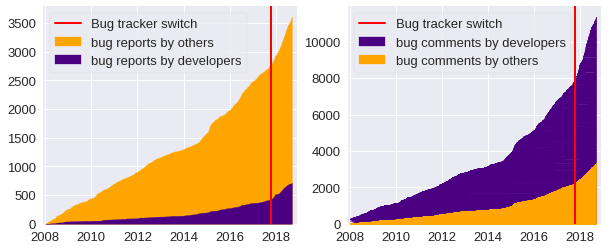

In [25]:
def local():

  ax1 = plt.subplot(1,2,1)
  plt.fill_between(issues.index,issues.agg({'count':'cumsum'})['count'],label='bug reports by others',color='orange')
  plt.fill_between(issues.index,issues.agg({'dev_count':'cumsum'})['dev_count'],label='bug reports by developers',color='indigo')
  plt.axvline(x=migration_date,color='red',lw=2,label='Bug tracker switch')
  plt.legend()
  plt.ylim(ymin=0)

  plt.subplot(1,2,2,sharex=ax1)
  plt.fill_between(comments.index,comments.agg({'count':'cumsum'})['count'],label='bug comments by developers',color='indigo')
  plt.fill_between(comments.index,comments.agg({'other_count':'cumsum'})['other_count'],label='bug comments by others',color='orange')
  plt.axvline(x=migration_date,color='red',lw=2,label='Bug tracker switch')
  plt.legend()
  plt.ylim(ymin=0)

  plt.xlim(xmin=pd.datetime(2007,12,1),xmax=pd.datetime(2018,12,1))

  plt.savefig('cumulative_bugs_and_comments.eps')

local()

### Cumulative number of pull requests on the Coq GitHub repository

In [0]:
implementors_workshops = [
    pd.datetime(2015,6,22),
    pd.datetime(2016,5,30),
    pd.datetime(2017,6,12),
    pd.datetime(2018,5,28)
]

def prs_vertical_lines():
  for date in implementors_workshops:
    line = plt.axvline(x=date,color='black', linestyle="-",lw=0.5)
  line.set_label('Coq Implementors Workshops')
  plt.axvline(x=pd.datetime(2017,2,3),color='black', linestyle="--",lw=1.2,label='Introduction of systematic CI testing')

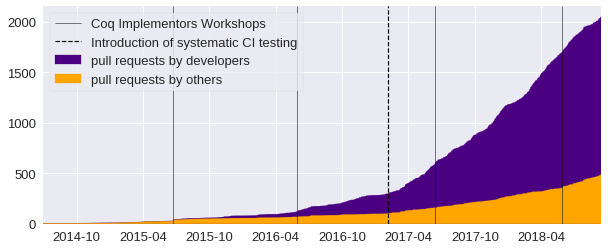

In [27]:
def local():

  plt.fill_between(prs.index,prs.agg({'count':'cumsum'})['count'],label='pull requests by developers',color='indigo')
  plt.fill_between(prs.index,prs.agg({'other_count':'cumsum'})['other_count'],label='pull requests by others',color='orange')
  prs_vertical_lines()
  plt.xlim(xmin=pd.datetime(2014,7,1),xmax=prs.index[-1])
  plt.ylim(ymin=0)
  plt.legend()

local()

### Cumulative number of commits since March, 2006

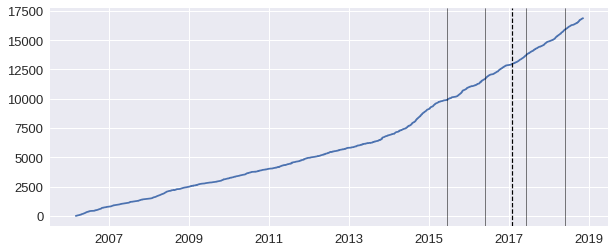

In [28]:
def local():
  
  plt.plot(commits.agg({'count':'cumsum'}))
  prs_vertical_lines()
  
local()

### Evolution of pull request creation for developers / external contributors

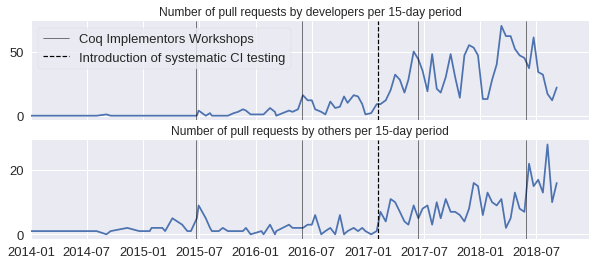

In [29]:
def local():

  ax1 = plt.subplot(2,1,1)
  plt.plot(prs_15D['dev_count'],label='')
  prs_vertical_lines()
  plt.legend()
  plt.title('Number of pull requests by developers per 15-day period')

  plt.setp(ax1.get_xticklabels(), visible=False)

  plt.subplot(2,1,2,sharex=ax1)
  plt.plot(prs_15D['other_count'],label='')
  prs_vertical_lines()
  plt.title('Number of pull requests by others per 15-day period')

  plt.xlim(xmin=pd.datetime(2014,1,1))

local()

### Variation of bug reporting by month and by hour

#### Average number of bug reports per month (over years 2008-2017)

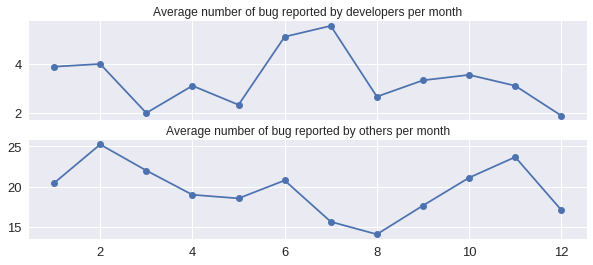

In [30]:
def local():

  issue_by_month_abs = issues[issues.index < pd.datetime(2017,1,1)].resample('M').sum()

  average_issue_nb_by_month = issue_by_month_abs.assign(
      month=issue_by_month_abs.index.month
  ).groupby('month').mean()

  ax1 = plt.subplot(2, 1, 1)
  plt.plot(average_issue_nb_by_month['dev_count'],'-o')
  plt.title('Average number of bug reported by developers per month')

  plt.setp(ax1.get_xticklabels(), visible=False)

  plt.subplot(2, 1, 2)
  plt.plot(average_issue_nb_by_month['other_count'],'-o')
  plt.title('Average number of bug reported by others per month')

local()

#### Distribution of bug creation by hour of the day before (since 2016) / after the switch.

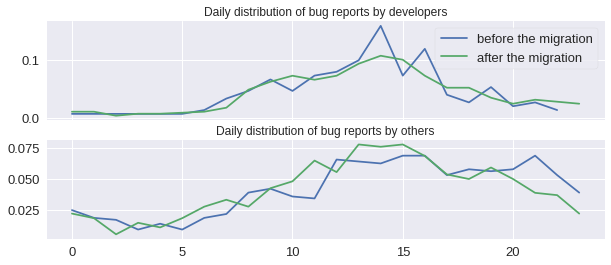

In [31]:
def local():

  def bug_by_hour(cond):
    return issues.assign(hour=issues.index.hour)[cond].groupby('hour').sum()['count'] / len(issues[cond])

  cond_before = (issues['post_migration'] == False) & (issues.index >= pd.datetime(2016,1,1))
  cond_after = issues['post_migration'] == True
  dev_issues = issues['author'].isin(devs)

  ax1 = plt.subplot(2, 1, 1)
  plt.plot(bug_by_hour(cond_before & dev_issues),label='before the migration')
  plt.plot(bug_by_hour(cond_after & dev_issues),label='after the migration')
  plt.title('Daily distribution of bug reports by developers')
  plt.legend()
  plt.setp(ax1.get_xticklabels(), visible=False)

  plt.subplot(2, 1, 2)
  plt.plot(bug_by_hour(cond_before & ~dev_issues),label='before the migration')
  plt.plot(bug_by_hour(cond_after & ~dev_issues),label='after the migration')
  plt.title('Daily distribution of bug reports by others')

local()

### Graphs with new release dates

The dates of new releases were obtained from the corresponding news items at https://coq.inria.fr/news/.

In [0]:
# Major releases

major_releases = [
    pd.datetime(2009,2,15), # 8.2
    pd.datetime(2010,10,14), # 8.3
    pd.datetime(2012,8,12), # 8.4
    pd.datetime(2016,1,21), # 8.5
    pd.datetime(2016,12,14), # 8.6
    pd.datetime(2017,10,17), # 8.7
    pd.datetime(2018,4,17) # 8.8
]

# Beta releases

beta_releases = [
    pd.datetime(2008,6,17), # 8.2 beta
    pd.datetime(2010,2,16), # 8.3 beta
    pd.datetime(2011,12,27), # 8.4 beta
    pd.datetime(2015,1,21), # 8.5 beta 1
    pd.datetime(2015,4,22), # 8.5 beta 2
    pd.datetime(2015,11,11), # 8.5 beta 3
    pd.datetime(2016,11,19), # 8.6 beta
    pd.datetime(2017,9,6), # 8.7 beta 1
    pd.datetime(2017,10,6), # 8.7 beta 2
    pd.datetime(2018,3,18) # 8.8 beta
]

def release_vertical_lines():
  for release in major_releases:
    line=plt.axvline(x=release,color='black',linestyle="-",lw=1.2)
  line.set_label('major releases')
  for release in beta_releases:
    line=plt.axvline(x=release,color='black',linestyle="--",lw=0.8)
  line.set_label('beta releases')
  plt.axvline(x=migration_date,color='red',linestyle='-',lw=1.5,label='bug tracker switch')

#### Number of bugs

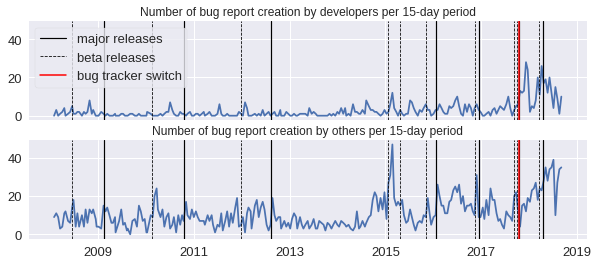

In [33]:
def local():

  ax1 = plt.subplot(2,1,1)
  plt.plot(issues_15D['dev_count'],label='')
  release_vertical_lines()
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.title('Number of bug report creation by developers per 15-day period')

  plt.legend(loc='upper left')

  plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
  plt.plot(issues_15D['other_count'],label='')
  release_vertical_lines()
  plt.title('Number of bug report creation by others per 15-day period')

  plt.savefig('bug_nb_with_releases.eps')

local()

#### Number of comments

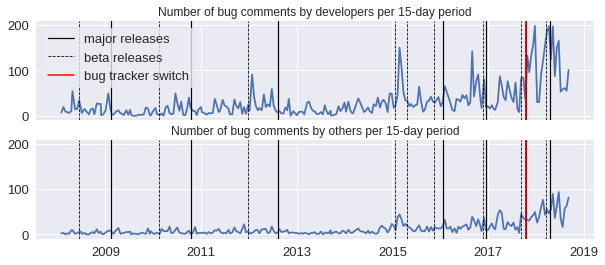

In [34]:
def local():

  ax1 = plt.subplot(2,1,1)
  plt.plot(comments_15D['dev_count'],label='')
  release_vertical_lines()
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.title('Number of bug comments by developers per 15-day period')

  plt.legend(loc='upper left')

  plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
  plt.plot(comments_15D['other_count'],label='')
  release_vertical_lines()
  plt.title('Number of bug comments by others per 15-day period')

  plt.savefig('comments_with_releases.eps')

local()

#### Number of reporters

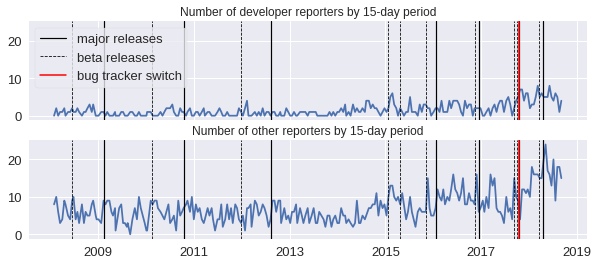

In [35]:
def local():

  ax1 = plt.subplot(2,1,1)
  plt.plot(issues_15D['dev_author'],label='')
  release_vertical_lines()
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.title('Number of developer reporters by 15-day period')

  plt.legend(loc='upper left')

  plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
  plt.plot(issues_15D['other_author'],label='')
  release_vertical_lines()
  plt.title('Number of other reporters by 15-day period')

local()

#### Number of commentators

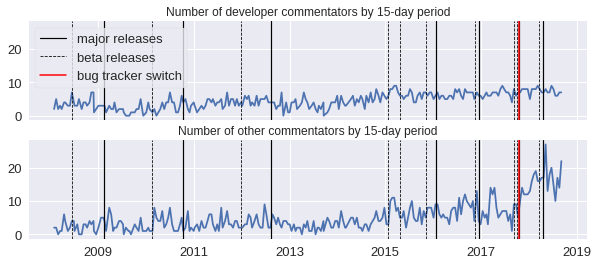

In [36]:
def local():

  ax1 = plt.subplot(2,1,1)
  plt.plot(comments_15D['dev_author'],label='')
  release_vertical_lines()
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.title('Number of developer commentators by 15-day period')

  plt.legend(loc='upper left')

  plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
  plt.plot(comments_15D['other_author'],label='')
  release_vertical_lines()
  plt.title('Number of other commentators by 15-day period')

local()

#### Number of commits

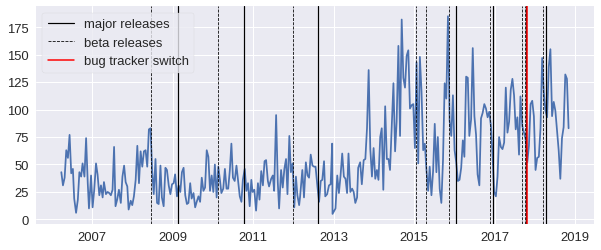

In [37]:
def local():

  plt.plot(commits_15D['count'],label='')
  release_vertical_lines()
  plt.legend(loc='upper left')

local()

#### Number of committers by 30-day period

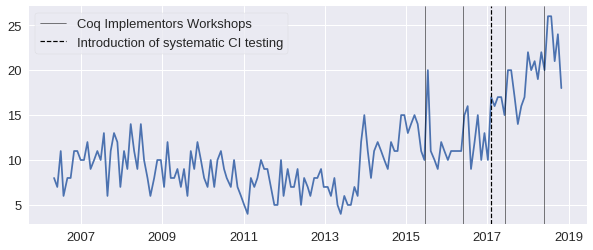

In [38]:
def local():

  plt.plot(commits_30D['author'],label='')
  prs_vertical_lines()
  plt.legend(loc='upper left')

local()

#### Number of new reporters by 30-day period

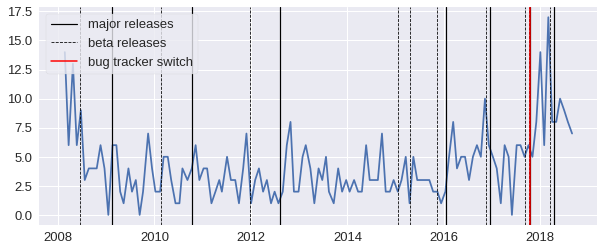

In [39]:
def local():

  plt.plot(issues_30D['new'],label='')
  release_vertical_lines()
  plt.legend(loc='upper left')

local()

#### Number of new commentators by 30-day period 

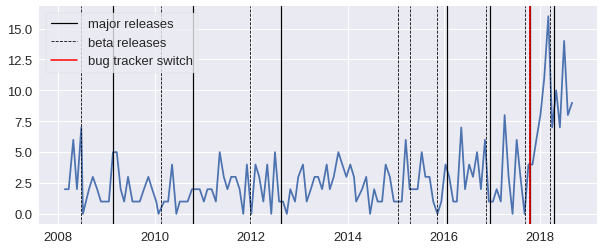

In [40]:
def local():

  plt.plot(comments_30D['new'],label='')
  release_vertical_lines()
  plt.legend(loc='upper left')

local()

#### Number of new committers by 30-day period

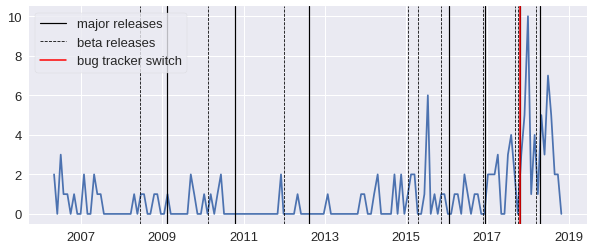

In [41]:
def local():

  plt.plot(commits_30D['new'],label='')
  release_vertical_lines()
  plt.legend(loc='upper left')

local()

### Number of bugs opened by individual developers per 30-day period

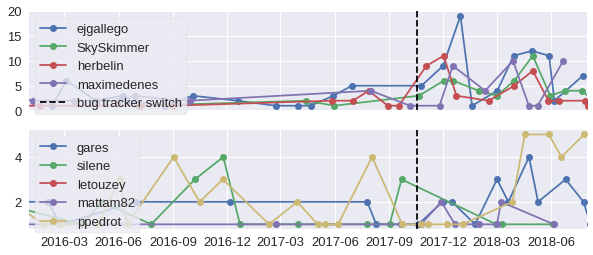

In [42]:
def local():

  def reporter_graph(author):
    _,_,issues_30D = df_15D_30D(issues[
        (issues['author'] == author)
    ])
    plt.plot(issues_30D['count'],'-o',label=author)

  ax1 = plt.subplot(2,1,1)
  for reporter in ['ejgallego','SkySkimmer','herbelin','maximedenes']:
    reporter_graph(reporter)
  plt.axvline(x=migration_date,linestyle='--',color='black',label='bug tracker switch')
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.legend(loc='upper left')

  plt.subplot(2,1,2,sharex=ax1)
  for reporter in ['gares','silene','letouzey','mattam82','ppedrot']:
    reporter_graph(reporter)
  plt.axvline(x=migration_date,linestyle='--',color='black',label='')
  plt.legend(loc='upper left')

  plt.xlim(xmin=pd.datetime(2016,1,1),xmax=pd.datetime(2018,7,31))

local()

### Biggest reporters (period of 300 days before to 300 days after the switch)

In [43]:
def local():

  issues_grouped_by_author = issues[
      (issues['reldate_30D'] >= -10) &
      (issues['reldate_30D'] < 10)
  ].groupby('author').sum().sort_values(
      'count',
      ascending=False
  )

  return issues_grouped_by_author.assign(
      bugs_before=issues_grouped_by_author['count']-issues_grouped_by_author['post_migration'].astype(int),
      bugs_after=issues_grouped_by_author['post_migration'].astype(int)
  )[['bugs_before','bugs_after']].head(10)

local()

,bugs_before,bugs_after
author,,
ejgallego,14,80
RalfJung,23,48
herbelin,11,43
SkySkimmer,5,48
tchajed,34,11
maximedenes,5,40
ppedrot,11,25
andres-erbsen,0,28
anton-trunov,0,27


### Biggest commentators (period of 300 days before to 300 days after the switch)

In [44]:
def local():

  comments_grouped_by_author = comments[
      (comments['reldate_30D'] >= -10) &
      (comments['reldate_30D'] < 10)
  ].groupby('author').sum().sort_values(
      'count',
      ascending=False
  )

  return comments_grouped_by_author.assign(
      bugs_before=comments_grouped_by_author['count']-comments_grouped_by_author['post_migration'].astype(int),
      bugs_after=comments_grouped_by_author['post_migration'].astype(int)
  )[['bugs_before','bugs_after']].head(10)

local()

,bugs_before,bugs_after
author,,
ejgallego,289,757
herbelin,157,325
maximedenes,89,367
ppedrot,86,268
SkySkimmer,18,305
gares,49,202
psteckler,118,91
RalfJung,81,125
mattam82,36,119


### Commenting rate over time: bug / pull request comparison

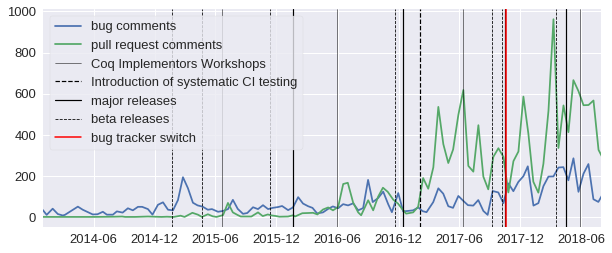

In [45]:
def local():

  plt.plot(comments_15D['count'],label='bug comments')
  plt.plot(pr_comments_15D['count'],label='pull request comments')
  prs_vertical_lines()
  release_vertical_lines()
  plt.xlim(xmin=pd.datetime(2014,1,1),xmax=pd.datetime(2018,7,31))
  plt.legend()

local()

## Results

We do Regressions in Discontinuity on a time window of 300 days before and after the switch for our four main outcomes. In addition we also include in this notebook the results for the number of new bug reporters and comentators. In the robustness check section, we will also do this for different time windows.

In [0]:
import statsmodels.formula.api as smf

def select_periods(df,period_nb):
  return df[
      (df['reldate'] >= -period_nb) &
      (df['reldate'] < period_nb)
  ]

def rd(data,variable):
  results = smf.ols(
      formula=variable + ' ~ after_switch + reldate + after_switch*reldate',
      data=data
  ).fit()
  
  def stars(p):
    if p < 0.01:
      return '***'
    elif p < 0.05:
      return '** '
    elif p < 0.1:
      return '*  '
    else:
      return '   '
  
  values = list(zip(*[
      results.params,
      map(stars,results.pvalues),
      results.bse,
      results.pvalues
  ]))
  
  print(f'Outcome variable:\t{variable}')
  print(f'No of observations:\t{results.nobs}\n')
  print('                      \tcoef\t\tstd err\t\tP>|t|')
  print('-----------------------------------------------------------------')
  print('after switch          \t%.3g %s  \t(%.3g)   \t%.3g' % tuple(values[1]))
  print('after switch*reldate\t%.3g %s  \t(%.3g)   \t%.3g' % tuple(values[3]))
  print('reldate               \t%.3g %s  \t(%.3g)   \t%.3g' % tuple(values[2]))
  print('constant              \t%.3g %s  \t(%.3g)   \t%.3g\n\n' % tuple(values[0]))
  return results

def plot_rd_line(index,results,color,label=''):
  period_nb = len(index) // 2
  plt.plot(index[:period_nb],results.predict()[:period_nb],color=color)
  plt.plot(index[period_nb:],results.predict()[period_nb:],color=color,label=label)

In [0]:
def hetero_analysis(data,variable,label_all,label_dev,label_others):

  data = select_periods(data,20)

  dev_variable = f'dev_{variable}'
  other_variable = f'other_{variable}'
  
  everyone = rd(data,variable)
  devs = rd(data,dev_variable)
  others = rd(data,other_variable)

  plot_rd_line(data.index,devs,'blue')
  plt.plot(data[dev_variable],'.',color='blue',label=label_dev)
  
  plot_rd_line(data.index,others,'red')
  plt.plot(data[other_variable],'.',color='red',label=label_others)
  
  plot_rd_line(data.index,everyone,'black',label_all)

  plt.axvline(x=migration_date,color='black', linestyle='--')
  plt.legend()

### Number of reports

Outcome variable:	count
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	10.1 *    	(5.06)   	0.0541
after switch*reldate	0.717      	(0.438)   	0.11
reldate               	0.219      	(0.309)   	0.484
constant              	17.6 ***  	(3.71)   	3.11e-05


Outcome variable:	dev_count
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	8.79 **   	(3.55)   	0.0182
after switch*reldate	-0.335      	(0.307)   	0.283
reldate               	0.25      	(0.217)   	0.258
constant              	5.72 **   	(2.6)   	0.0346


Outcome variable:	other_count
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	1.27      	(4.16)   	0.761
after switch*reldate	1.05 ***  	(0.36)   	0.0060

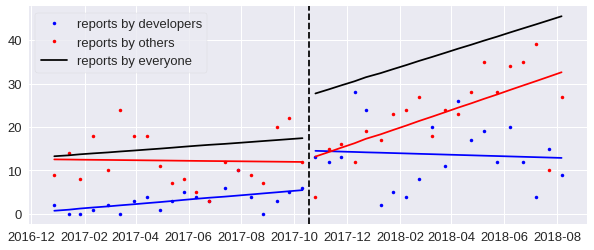

In [48]:
hetero_analysis(issues_15D,'count','reports by everyone','reports by developers','reports by others')
plt.savefig('bug_nb_rd.eps')

### Number of  distinct reporters

Outcome variable:	author
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	4.15      	(2.52)   	0.108
after switch*reldate	0.289      	(0.218)   	0.193
reldate               	0.111      	(0.154)   	0.477
constant              	12 ***  	(1.84)   	1.44e-07


Outcome variable:	dev_author
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	1.24      	(0.974)   	0.211
after switch*reldate	-0.156 *    	(0.0843)   	0.0731
reldate               	0.159 **   	(0.0596)   	0.0112
constant              	3.97 ***  	(0.714)   	2.65e-06


Outcome variable:	other_author
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	2.91      	(2.46)   	0.246
after switch*reldate	0.444 **   	(0.21

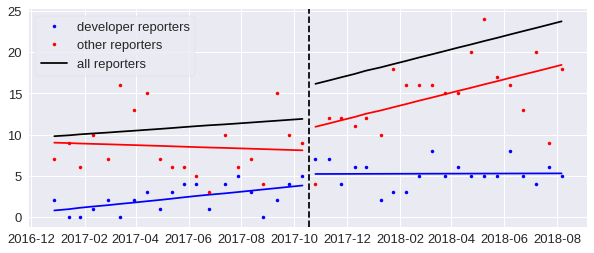

In [49]:
hetero_analysis(issues_15D,'author','all reporters','developer reporters','other reporters')
plt.savefig('reporter_nb_rd.eps')

### Number of new reporters

We hoped that the switch of bug tracker would help to encourage more users to report bugs by making it easier for them. Even if graphically there seems that there was such an increase, our results are not statistically significant. It is not really surprising given that we only have 20 observations (because the new reporters are not frequent enough to allow us consider periods of less than 30 days).

Outcome variable:	new
No of observations:	20.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	3.4      	(2.82)   	0.245
after switch*reldate	-0.152      	(0.486)   	0.759
reldate               	0.218      	(0.344)   	0.535
constant              	5.6 **   	(2.13)   	0.0184




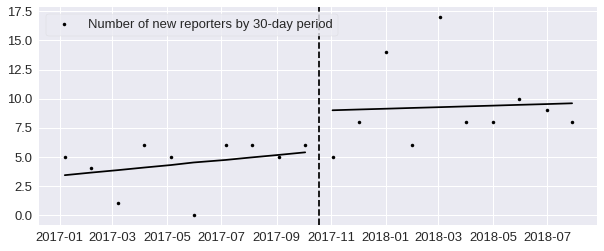

In [50]:
def local():

  data = select_periods(issues_30D,10)

  results = rd(data,'new')
  
  plot_rd_line(data.index,results,'black')
  plt.plot(data['new'],'.',color='black',label='Number of new reporters by 30-day period')

  plt.axvline(x=migration_date,color='black', linestyle='--')
  plt.legend()

local()

### Number of comments

Outcome variable:	count
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	84.7 **   	(35.5)   	0.0225
after switch*reldate	-2.1      	(3.07)   	0.5
reldate               	1.95      	(2.17)   	0.376
constant              	86.6 ***  	(26)   	0.00204


Outcome variable:	dev_count
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	72.2 **   	(27.9)   	0.0138
after switch*reldate	-2.79      	(2.41)   	0.254
reldate               	1.65      	(1.71)   	0.34
constant              	59.7 ***  	(20.4)   	0.00598


Outcome variable:	other_count
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	12.5      	(11.1)   	0.267
after switch*reldate	0.698      	(0.957)   	0.471
reldate 

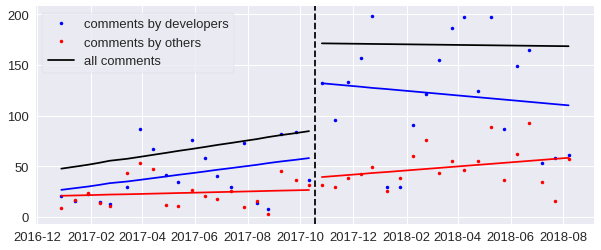

In [51]:
hetero_analysis(comments_15D,'count','all comments','comments by developers','comments by others')

### Number of commentators

Outcome variable:	author
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	7.48 ***  	(2.63)   	0.00737
after switch*reldate	0.238      	(0.228)   	0.303
reldate               	-0.00977      	(0.161)   	0.952
constant              	13.4 ***  	(1.93)   	3.65e-08


Outcome variable:	dev_author
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	0.763      	(0.684)   	0.272
after switch*reldate	-0.0684      	(0.0592)   	0.256
reldate               	0.0368      	(0.0419)   	0.385
constant              	7.04 ***  	(0.502)   	3.67e-16


Outcome variable:	other_author
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	6.72 ***  	(2.3)   	0.00598
after switch*reldate	0.307   

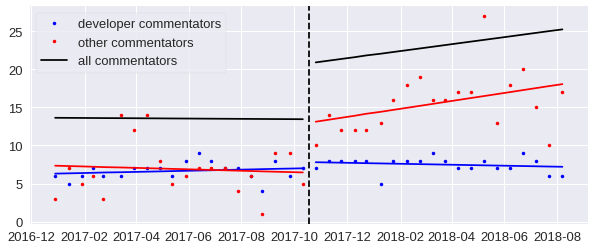

In [52]:
hetero_analysis(comments_15D,'author','all commentators','developer commentators','other commentators')
plt.savefig('commentator_nb_rd.eps')

### Number of committers

Outcome variable:	author
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	-2.41      	(1.51)   	0.12
after switch*reldate	-0.0331      	(0.131)   	0.802
reldate               	0.281 ***  	(0.0926)   	0.00445
constant              	15.4 ***  	(1.11)   	5.6e-16




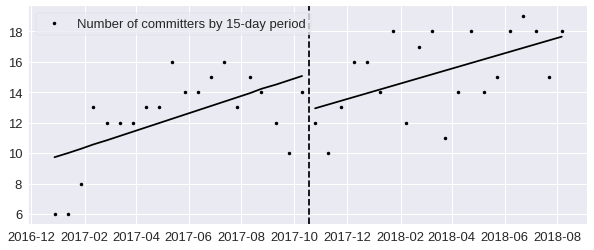

In [53]:
def local():

  data = select_periods(commits_15D,20)

  results = rd(data,'author')
  
  plot_rd_line(data.index,results,'black')
  plt.plot(data['author'],'.',color='black',label='Number of committers by 15-day period')

  plt.axvline(x=migration_date,color='black', linestyle='--')
  plt.legend()

local()

### Number of new commentators

Outcome variable:	new
No of observations:	20.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	3.79      	(2.91)   	0.211
after switch*reldate	0.37      	(0.503)   	0.473
reldate               	0.0848      	(0.356)   	0.814
constant              	3.27      	(2.21)   	0.158




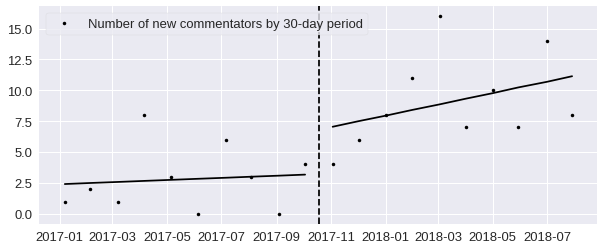

In [54]:
def local():

  data = select_periods(comments_30D,10)

  results = rd(data,'new')
  
  plot_rd_line(data.index,results,'black')
  plt.plot(data['new'],'.',color='black',label='Number of new commentators by 30-day period')

  plt.axvline(x=migration_date,color='black', linestyle='--')
  plt.legend()

local()

### Number of new committers

Outcome variable:	new
No of observations:	20.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	2.7      	(2.06)   	0.208
after switch*reldate	0.0848      	(0.356)   	0.815
reldate               	-0.0485      	(0.252)   	0.85
constant              	1.53      	(1.56)   	0.341




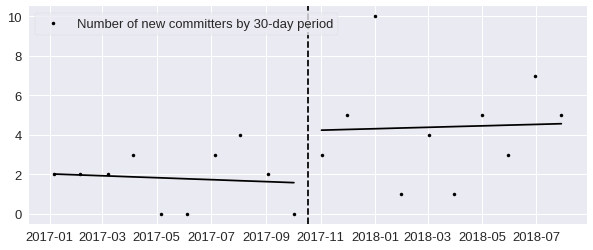

In [55]:
def local():

  data = select_periods(commits_30D,10)

  results = rd(data,'new')
  
  plot_rd_line(data.index,results,'black')
  plt.plot(data['new'],'.',color='black',label='Number of new committers by 30-day period')

  plt.axvline(x=migration_date,color='black', linestyle='--')
  plt.legend()

local()

## Robustness checks


### Removing the two 15-day periods after the switch (and the 8.7.0 release)

None of our results are affected by this robustness check giving strong evidence that our results are not driven by the release of the version 8.7.0 of Coq. 

In [0]:
issues_15D_check1 = select_periods(
    issues_15D[
        (issues_15D['reldate'] != 0) &
        (issues_15D['reldate'] != 1)
    ],
    20
)

comments_15D_check1 = select_periods(
    comments_15D[
        (comments_15D['reldate'] != 0) &
        (comments_15D['reldate'] != 1)
    ],
    20
)

#### Number of reports

In [57]:
def local():

  rd(issues_15D_check1,'count')
  rd(issues_15D_check1,'dev_count')
  rd(issues_15D_check1,'other_count')

local()

Outcome variable:	count
No of observations:	38.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	13.5 **   	(5.59)   	0.021
after switch*reldate	0.452      	(0.473)   	0.346
reldate               	0.219      	(0.307)   	0.481
constant              	17.6 ***  	(3.68)   	3.14e-05


Outcome variable:	dev_count
No of observations:	38.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	9.86 **   	(4.05)   	0.0204
after switch*reldate	-0.416      	(0.343)   	0.233
reldate               	0.25      	(0.223)   	0.27
constant              	5.72 **   	(2.67)   	0.0391


Outcome variable:	other_count
No of observations:	38.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	3.67      	(4.61)   	0.431
after switch*reldate	0.868 **   	(0.39)   	0.032

#### Number of reporters

In [58]:
def local():

  rd(issues_15D_check1,'count')
  rd(issues_15D_check1,'dev_author')
  rd(issues_15D_check1,'other_author')

local()

Outcome variable:	count
No of observations:	38.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	13.5 **   	(5.59)   	0.021
after switch*reldate	0.452      	(0.473)   	0.346
reldate               	0.219      	(0.307)   	0.481
constant              	17.6 ***  	(3.68)   	3.14e-05


Outcome variable:	dev_author
No of observations:	38.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	0.269      	(1.05)   	0.799
after switch*reldate	-0.082      	(0.0889)   	0.363
reldate               	0.159 ***  	(0.0577)   	0.00922
constant              	3.97 ***  	(0.692)   	1.84e-06


Outcome variable:	other_author
No of observations:	38.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	4.7 *    	(2.66)   	0.0867
after switch*reldate	0.307      	(0.2

#### Number of comments

In [59]:
def local():

  rd(comments_15D_check1,'count')
  rd(comments_15D_check1,'dev_count')
  rd(comments_15D_check1,'other_count')

local()

Outcome variable:	count
No of observations:	38.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	98.5 **   	(40.2)   	0.0197
after switch*reldate	-3.14      	(3.4)   	0.363
reldate               	1.95      	(2.21)   	0.384
constant              	86.6 ***  	(26.5)   	0.00245


Outcome variable:	dev_count
No of observations:	38.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	81.2 **   	(31.6)   	0.0148
after switch*reldate	-3.47      	(2.67)   	0.203
reldate               	1.65      	(1.74)   	0.349
constant              	59.7 ***  	(20.8)   	0.00701


Outcome variable:	other_count
No of observations:	38.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	17.3      	(12.5)   	0.177
after switch*reldate	0.335      	(1.06)   	0.754
reld

#### Number of commentators

In [60]:
def local():

  rd(comments_15D_check1,'count')
  rd(comments_15D_check1,'dev_author')
  rd(comments_15D_check1,'other_author')

local()

Outcome variable:	count
No of observations:	38.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	98.5 **   	(40.2)   	0.0197
after switch*reldate	-3.14      	(3.4)   	0.363
reldate               	1.95      	(2.21)   	0.384
constant              	86.6 ***  	(26.5)   	0.00245


Outcome variable:	dev_author
No of observations:	38.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	0.929      	(0.777)   	0.24
after switch*reldate	-0.0812      	(0.0657)   	0.225
reldate               	0.0368      	(0.0427)   	0.394
constant              	7.04 ***  	(0.511)   	1.85e-15


Outcome variable:	other_author
No of observations:	38.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	7.44 ***  	(2.6)   	0.00722
after switch*reldate	0.251      	(0.22) 

### Changing the time window

Our main results continue to hold.

In [0]:
other_periods = [
    (20,select_periods(issues_15D,20),select_periods(comments_15D,20)),
    (15,select_periods(issues_15D,15),select_periods(comments_15D,15)),
    (10,select_periods(issues_15D,10),select_periods(comments_15D,10)),
]

#### Number of reports

When we reduce the time window, we can still observe a slightly less statistically relevant (p < 10% instead of p < 5%) jump of bug report creation by developers. This is probably due to an increase of the standard errors given the decrease in the number of data points. However, the strongly statistically relevant result on the post-switch slope for non-developers is not maintained when reducing to 10 periods on each side of the switch. Getting statistically significant results on a slope becomes particularly difficult when reducing the number of observations.

In [62]:
for period_nb, data, _ in other_periods:
  print(f'Impact on the number of bug reports by developers ({period_nb} periods)\n')
  rd(data,'dev_count')

Impact on the number of bug reports by developers (20 periods)

Outcome variable:	dev_count
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	8.79 **   	(3.55)   	0.0182
after switch*reldate	-0.335      	(0.307)   	0.283
reldate               	0.25      	(0.217)   	0.258
constant              	5.72 **   	(2.6)   	0.0346


Impact on the number of bug reports by developers (15 periods)

Outcome variable:	dev_count
No of observations:	30.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	7.58      	(4.45)   	0.1
after switch*reldate	-0.0464      	(0.513)   	0.929
reldate               	0.214      	(0.363)   	0.56
constant              	5.51      	(3.3)   	0.107


Impact on the number of bug reports by developers (10 periods)

Outcome variable:	dev_count
No of observations:	20.0

                   

In [63]:
for period_nb, data, _ in other_periods:
  print(f'Impact on the number of bug reports by others ({period_nb} periods)\n')
  rd(data,'other_count')

Impact on the number of bug reports by others (20 periods)

Outcome variable:	other_count
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	1.27      	(4.16)   	0.761
after switch*reldate	1.05 ***  	(0.36)   	0.00601
reldate               	-0.0308      	(0.255)   	0.904
constant              	11.9 ***  	(3.05)   	0.000394


Impact on the number of bug reports by others (15 periods)

Outcome variable:	other_count
No of observations:	30.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	-0.458      	(4.03)   	0.91
after switch*reldate	1.65 ***  	(0.465)   	0.00149
reldate               	-0.175      	(0.328)   	0.599
constant              	11 ***  	(2.99)   	0.00106


Impact on the number of bug reports by others (10 periods)

Outcome variable:	other_count
No of observations:	20.0

                

#### Number of reporters

 We keep strong statistical significance when reducing to 15 periods on each side but not when reduing further to just 10. Looking deeply it seem that in this case the noise in our data may be playing a role. Indeed, when reducing the window to 10 periods on each side, several coefficients change signs sugesting that an uncommon data point would increase its influence when reducing the total number of observations. In particular, the third observation starting from the switch to the left seems to be playing this role. 

In [64]:
for period_nb, data, _ in other_periods:
  print(f'Impact on the number of distinct other reporters by 15-day period ({period_nb} periods)\n')
  rd(data,'other_author')

Impact on the number of distinct other reporters by 15-day period (20 periods)

Outcome variable:	other_author
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	2.91      	(2.46)   	0.246
after switch*reldate	0.444 **   	(0.213)   	0.0442
reldate               	-0.0489      	(0.151)   	0.748
constant              	8.04 ***  	(1.81)   	7.9e-05


Impact on the number of distinct other reporters by 15-day period (15 periods)

Outcome variable:	other_author
No of observations:	30.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	1.81      	(2.64)   	0.499
after switch*reldate	1.1 ***  	(0.305)   	0.00124
reldate               	-0.254      	(0.215)   	0.25
constant              	6.77 ***  	(1.96)   	0.00189


Impact on the number of distinct other reporters by 15-day period (10 periods)

Outcome var

#### Number of comments

The results on the jump in the number of comments remain robust with similar magnitudes of the estimate arround 70 comments  but losing some level of significativity due to the decrease of the number of observation which increases standard errors. However, we keep a p < 10% statistical significance for comments by developers on 15 and 10 periods on each side. On the total number of comments, the result pases just above the 10 % significatity for 10 periods on each side, mainly due to an increase in the standard error since the magnitude remains verly similar to the estimate for 15 periods on each side. 

In [65]:
for period_nb, _, data in other_periods:
  print(f'Impact on the number of comments by everyone ({period_nb} periods)\n')
  rd(data,'count')

Impact on the number of comments by everyone (20 periods)

Outcome variable:	count
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	84.7 **   	(35.5)   	0.0225
after switch*reldate	-2.1      	(3.07)   	0.5
reldate               	1.95      	(2.17)   	0.376
constant              	86.6 ***  	(26)   	0.00204


Impact on the number of comments by everyone (15 periods)

Outcome variable:	count
No of observations:	30.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	77.6 *    	(38.7)   	0.0555
after switch*reldate	5.89      	(4.47)   	0.198
reldate               	-1.31      	(3.16)   	0.682
constant              	66.9 **   	(28.7)   	0.0279


Impact on the number of comments by everyone (10 periods)

Outcome variable:	count
No of observations:	20.0

                      	coef		std err		P>|t|
-------

In [66]:
for period_nb, _, data in other_periods:
  print(f'Impact on the number of comments by developers ({period_nb} periods)\n')
  rd(data,'dev_count')

Impact on the number of comments by developers (20 periods)

Outcome variable:	dev_count
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	72.2 **   	(27.9)   	0.0138
after switch*reldate	-2.79      	(2.41)   	0.254
reldate               	1.65      	(1.71)   	0.34
constant              	59.7 ***  	(20.4)   	0.00598


Impact on the number of comments by developers (15 periods)

Outcome variable:	dev_count
No of observations:	30.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	64.1 *    	(32.3)   	0.0576
after switch*reldate	2.99      	(3.72)   	0.429
reldate               	-0.454      	(2.63)   	0.865
constant              	47 *    	(23.9)   	0.0602


Impact on the number of comments by developers (10 periods)

Outcome variable:	dev_count
No of observations:	20.0

                      	coef		s

#### Number of commentators

The results on the jump in distinct commentators remain robust with similar magnitudes of the estimate but losing some level of significativity (passing from p < 1% to p < 5% for 10 periods on each side) due to the decrease of the number of observation which increases standard errors.

In [67]:
for period_nb, _, data in other_periods:
  print(f'Impact on the number of distinct commentators by 15-day period ({period_nb} periods)\n')
  rd(data,'author')

Impact on the number of distinct commentators by 15-day period (20 periods)

Outcome variable:	author
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	7.48 ***  	(2.63)   	0.00737
after switch*reldate	0.238      	(0.228)   	0.303
reldate               	-0.00977      	(0.161)   	0.952
constant              	13.4 ***  	(1.93)   	3.65e-08


Impact on the number of distinct commentators by 15-day period (15 periods)

Outcome variable:	author
No of observations:	30.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	8.64 ***  	(2.62)   	0.00286
after switch*reldate	1.1 ***  	(0.303)   	0.00117
reldate               	-0.518 **   	(0.214)   	0.0228
constant              	10.3 ***  	(1.95)   	1.51e-05


Impact on the number of distinct commentators by 15-day period (10 periods)

Outcome variable:	author

In [68]:
for period_nb, _, data in other_periods:
  print(f'Impact on the number of distinct commentators by 15-day period ({period_nb} periods)\n')
  rd(data,'other_author')

Impact on the number of distinct commentators by 15-day period (20 periods)

Outcome variable:	other_author
No of observations:	40.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	6.72 ***  	(2.3)   	0.00598
after switch*reldate	0.307      	(0.199)   	0.132
reldate               	-0.0466      	(0.141)   	0.742
constant              	6.41 ***  	(1.69)   	0.000534


Impact on the number of distinct commentators by 15-day period (15 periods)

Outcome variable:	other_author
No of observations:	30.0

                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	7.6 ***  	(2.3)   	0.00282
after switch*reldate	1.07 ***  	(0.266)   	0.00043
reldate               	-0.482 **   	(0.188)   	0.0164
constant              	3.74 **   	(1.71)   	0.0376


Impact on the number of distinct commentators by 15-day period (10 periods)

Outcome variable:

## Apendix

### Handy function to generate LaTeX summaries for our heterogeneous analyses

In [0]:
def hetero_analysis_latex(data,variable):

  data = select_periods(data,20)
  
  everyone = rd(data,variable)
  devs = rd(data,f'dev_{variable}')
  others = rd(data,f'other_{variable}')
  
  def stars(p):
    if p < 0.01:
      return '***'
    elif p < 0.05:
      return '**'
    elif p < 0.1:
      return '*'
    else:
      return ''
  
  def row(name,i):
    return '%s & %.3g%s & %.3g%s & %.3g%s \\\\\n' % (
        name,
        everyone.params[i],
        stars(everyone.pvalues[i]),
        devs.params[i],
        stars(devs.pvalues[i]),
        others.params[i],
        stars(others.pvalues[i])
    ) + '& (%.3g) & (%.3g) & (%.3g) \\\\\n' % (
        everyone.bse[i],
        devs.bse[i],
        others.bse[i]
    ) + '\\hline\n'
  
  latex = """\\begin{tabular}{|r|c|c|c|}
\\hline
&  Total & Developers & Others \\\\
\\hline
"""
  latex += row('$\\mbox{\\emph{After switch}}_p$',1)
  latex += row('$\\mbox{\\emph{Relative date}}_p * \\mbox{\\emph{After switch}}_p$',3)
  latex += row('$\\mbox{\\emph{Relative date}}_p$',2)
  latex += row('Constant',0)
  latex += 'Observation number & %d & %d & %d \\\\\n' % (
      everyone.nobs,
      devs.nobs,
      others.nobs
  )
  latex += '\\hline\n\\end{tabular}'
  
  print(latex)